## Defensive Capacity

#### Load data & packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('/Users/pgule/Documents/Sample Data/epl.csv', delimiter=',')
#df = pd.read_csv('/Users/luisalawson/Downloads/Sample Data/epl.csv', delimiter=';')

### General grouping of data into dfs

In [3]:
df_prop = pd.DataFrame({
    'column_name': df.columns,
    'data_type': df.dtypes.values
})

In [4]:
df_vals = pd.DataFrame({
    'column_name': df.columns,
    'column_values': [set(df[col].tolist()) for col in df.columns],
    'unique_value_count': [len(set(df[col].tolist())) for col in df.columns]
})

In [5]:
df_vals

,column_name,column_values,unique_value_count
0,season_id,{2012},1
1,match_id,"{442368, 442369, 442370, 442371, 442372, 44237...",380
2,home_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
3,home_team_name,"{Wigan Athletic, Liverpool, Tottenham Hotspur,...",20
4,away_team_id,"{1, 3, 4, 6, 7, 8, 11, 14, 20, 21, 35, 43, 45,...",20
5,away_team_name,"{Wigan Athletic, Liverpool, Tottenham Hotspur,...",20
6,id,"{543162368, 1138753537, 123731970, 920649732, ...",648883
7,event_id,"{1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...",1160
8,date,"{18Nov2012, 17Nov2012, 25Aug2012, 05Nov2012, 0...",107
9,time,"{4:03:58 PM, 9:32:18 PM, 4:40:48 PM, 3:19:15 P...",31752


### Define team_id: team_name dictionary

In [6]:
teams1 = df['home_team_name'].unique()
teams2 = df['away_team_name'].unique()

teams = set(teams2) | set(teams2)

In [7]:
team_id_name_dict = {}

In [8]:
for team in teams:
    team_id = df[df['home_team_name'] == team]['home_team_id'].values[0]
    team_id_name_dict[team_id] = team

In [9]:
team_id_name_dict

{np.int64(111): 'Wigan Athletic',
 np.int64(14): 'Liverpool',
 np.int64(6): 'Tottenham Hotspur',
 np.int64(80): 'Swansea City',
 np.int64(20): 'Southampton',
 np.int64(108): 'Reading',
 np.int64(21): 'West Ham United',
 np.int64(4): 'Newcastle United',
 np.int64(35): 'West Bromwich Albion',
 np.int64(52): 'Queens Park Rangers',
 np.int64(11): 'Everton',
 np.int64(54): 'Fulham',
 np.int64(7): 'Aston Villa',
 np.int64(56): 'Sunderland',
 np.int64(3): 'Arsenal',
 np.int64(8): 'Chelsea',
 np.int64(1): 'Manchester United',
 np.int64(45): 'Norwich City',
 np.int64(43): 'Manchester City',
 np.int64(110): 'Stoke City'}

### Set relevant events

In [10]:
one_defensive_events = ['Interception', 'Save', 'Ball recovery', 'Error', 'Offside provoked', 'Shield ball opp']
cero_defensive_events = ['Foul', 'Challenge']
binary_defensive_events = ['Tackle', 'Clearance', 'Aerial']

In [11]:
defensive_events = {
    'Interception': {'successful': 1},
    'Save': {'successful': 1},
    'Ball recovery': {'successful': 1},
    'Error': {'unsuccessful': 1},
    'Offside provoked': {'successful': 1},
    'Shield ball opp': {'successful': 1},
    'Challenge': {'unsuccessful': 0},
    'Foul': {'unsuccessful': 0},  # Mantenemos solo el valor que te interesa
    'Tackle': {'successful': 1, 'unsuccessful': 0},
    'Clearance': {'successful': 1, 'unsuccessful': 0},
    'Aerial': {'successful': 1, 'unsuccessful': 0},
}



In [12]:
dangerous_first_half = (0,30)
dangerous_second_half = (70,100)

### Player event collection

In [13]:
player_stats = []
player_names = df['playerName'].unique()

In [14]:
for player_name in player_names:
    if player_name == 'nan' or player_name == 'NaN':
        pass
    else:
        # Para resultados más rápidos
        player_df = df[df['playerName'] == player_name]
        
        if not player_df.empty:
            # Recopilar equipo y asignar posición
            team_id = player_df['team_id'].iloc[0] if not player_df['team_id'].empty else None
            position = None

            # Buscar una posición válida --> se considera que substitute no es válido
            for pos in player_df['playerPosition']:
                if pos.lower() != 'substitute':  
                    position = pos
                    break  # cuando se encuentra, se detiene
            stats = {
                'player_name': player_name,
                'team_id': team_id,
                'position': position,
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                # Filtrar para excluir los Foul con outcome = 1
                if event == 'Foul':
                    total_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == 0)].shape[0]
                else:
                    total_event_count = player_df[player_df['description'] == event].shape[0]
                
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    # Filtrar para excluir Foul con outcome = 1 también aquí
                    if event == 'Foul':
                        successful_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == 0)].shape[0]
                    else:
                        successful_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcomes['successful'])].shape[0]
                    
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        if event == 'Foul' and outcome_value == 1:
                            continue  # Ignorar Foul con outcome = 1
                        outcome_event_count = player_df[(player_df['description'] == event) & (player_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            player_stats.append(stats)


In [15]:
df_players = pd.DataFrame(player_stats)

In [16]:
df_players

,player_name,team_id,position,total_interception,successful_interception,total_save,successful_save,total_ball_recovery,successful_ball_recovery,total_error,...,total_tackle,successful_tackle,unsuccessful_tackle,total_clearance,successful_clearance,unsuccessful_clearance,total_aerial,successful_aerial,unsuccessful_aerial,defensive_capacity
0,"Podolski, Lukas",3,Striker,15,15,2,2,68,68,3,...,32,25,7,23,10,13,77,25,52,0.543071
1,"Cazorla, Santiago",3,Midfielder,69,69,1,1,247,247,0,...,71,55,16,18,8,10,18,7,11,0.769384
2,"Vermaelen, Thomas",3,Defender,47,47,19,19,89,89,6,...,43,35,8,139,85,54,121,67,54,0.707031
3,"Walcott, Theo",3,Midfielder,11,11,0,0,89,89,0,...,16,15,1,5,0,5,25,7,18,0.742515
4,"Sessegnon, Stephane",56,Midfielder,11,11,2,2,97,97,1,...,20,17,3,7,3,4,80,17,63,0.558052
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518,"Ibe, Jordon",14,Midfielder,1,1,0,0,8,8,0,...,1,1,0,0,0,0,0,0,0,0.909091
519,"Knott, Billy",56,None,0,0,0,0,2,2,0,...,0,0,0,0,0,0,1,0,1,0.666667
520,"Mitchell, Adam",56,None,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0.000000
521,"Fyvie, Fraser",111,None,1,1,0,0,2,2,0,...,1,1,0,0,0,0,0,0,0,1.000000


In [17]:
df_sorted = (df_players[df_players['position'].notna()]).sort_values(by='defensive_capacity', ascending=False)

In [18]:
df_sorted_no_gk = df_sorted[df_sorted['position']!='Goalkeeper']

In [19]:
team_dfs = {}

In [20]:
for team_id in df_sorted['team_id'].unique():
    team_dfs[team_id] = df_sorted[df_sorted['team_id'] == team_id].copy()
    team_dfs[team_id]['team_name'] = team_dfs[team_id]['team_id'].map(team_id_name_dict)


In [21]:
defenders_sums = {}
midfielders_sums = {}
strikers_sums = {}

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_rename = 'successful_' + event.lower().replace(" ", "_")
        position_sums = df_players.groupby('position')[event_rename].sum()

        defenders_sums[event] = position_sums.get('Defender', 0)
        midfielders_sums[event] = position_sums.get('Midfielder', 0)
        strikers_sums[event] = position_sums.get('Striker', 0)
        

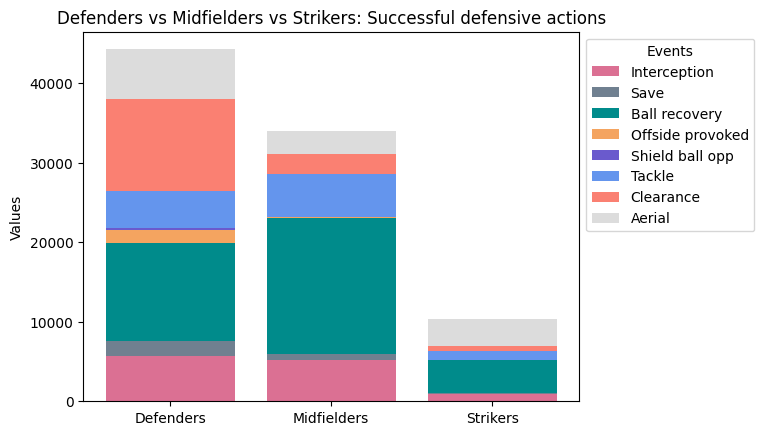

In [22]:
positions = ['Defenders', 'Midfielders', 'Strikers']

cumulative_sums = np.zeros(len(positions))

color_scheme = {
    'Ball recovery': 'darkcyan',
    'Interception': 'palevioletred',
    'Clearance': 'salmon',
    'Tackle': 'cornflowerblue',
    'Save': 'slategrey',
    'Error': 'darkseagreen',
    'Offside provoked': 'sandybrown',
    'Shield ball opp': 'slateblue',
    'Take on': 'crimson',
    'Foul': 'bisque',
    'Aerial': 'gainsboro'
}

fig, ax = plt.subplots()

for event, outcome in defensive_events.items():
    if 'successful' in outcome:
        event_values = np.array([defenders_sums[event], midfielders_sums[event], strikers_sums[event]])
        ax.bar(positions, event_values, bottom=cumulative_sums, label=event, color=color_scheme.get(event, 'gray'))
        cumulative_sums += event_values

ax.set_ylabel('Values')
ax.set_title('Defenders vs Midfielders vs Strikers: Successful defensive actions')
ax.legend(loc='upper left', bbox_to_anchor=(1, 1), title="Events")

plt.show()

### Manchester United

In [45]:
team_dfs[1][['player_name', 'team_name','position', 'defensive_capacity']]

,player_name,team_name,position,defensive_capacity
36,"de Gea, David",Manchester United,Goalkeeper,0.971429
345,"Lindegaard, Anders",Manchester United,Goalkeeper,0.948718
51,"Young, Ashley",Manchester United,Midfielder,0.776596
46,"Carrick, Michael",Manchester United,Midfielder,0.774878
53,"Oliveira, Anderson",Manchester United,Midfielder,0.766667
294,"Giggs, Ryan",Manchester United,Midfielder,0.748503
48,"Kagawa, Shinji",Manchester United,Midfielder,0.736842
344,"Ferdinand, Rio",Manchester United,Defender,0.732727
33,"Vidic, Nemanja",Manchester United,Defender,0.724528
443,"Jones, Phil",Manchester United,Defender,0.722892


In [24]:
player_names = [ 'Rooney, Wayne', 'van Persie, Robin', 'Cleverley, Tom', 'Evans, Jonny', 'Fletcher, Darren', 'Carrick, Michael', 'Evra, Patrice', 'da Silva, Rafael Pereira', 'Ferdinand, Rio', 'de Gea, David','Valencia, Luis Antonio' ]

In [25]:
paper_team_united = team_dfs[1][team_dfs[1]['player_name'].isin(player_names)]

In [26]:
paper_team_united[['player_name', 'team_name','position', 'defensive_capacity']]

,player_name,team_name,position,defensive_capacity
36,"de Gea, David",Manchester United,Goalkeeper,0.971429
46,"Carrick, Michael",Manchester United,Midfielder,0.774878
344,"Ferdinand, Rio",Manchester United,Defender,0.732727
47,"Cleverley, Tom",Manchester United,Midfielder,0.719807
38,"Evra, Patrice",Manchester United,Defender,0.717523
371,"Evans, Jonny",Manchester United,Defender,0.691450
292,"da Silva, Rafael Pereira",Manchester United,Defender,0.685934
32,"Valencia, Luis Antonio",Manchester United,Midfielder,0.669118
441,"Fletcher, Darren",Manchester United,Midfielder,0.653846
37,"Rooney, Wayne",Manchester United,Striker,0.650909


### Cálculo dc a nivel equipo

In [27]:
team_stats = []

In [28]:
for team_id in team_id_name_dict.keys():
    if team_id == 'nan' or team_id == 'NaN':
        pass
    
    else:
        team_df = df[df['team_id'] == team_id]
                    
        if not team_df.empty:
            # Recopilar equipo y asignar posición

            team_name =  team_id_name_dict.get(team_id) 
            
            stats = {
                'team_id': team_id,
                'team_name': team_name
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                # Filtrar para excluir los Foul con outcome = 1
                if event == 'Foul':
                    total_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                else:
                    total_event_count = team_df[team_df['description'] == event].shape[0]
                
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    # Filtrar para excluir Foul con outcome = 1 también aquí
                    if event == 'Foul':
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                    else:
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcomes['successful'])].shape[0]
                    
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        if event == 'Foul' and outcome_value == 1:
                            continue  # Ignorar Foul con outcome = 1
                        outcome_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            team_stats.append(stats)

In [29]:
df_teams = pd.DataFrame(team_stats)

In [30]:
df_teams

,team_id,team_name,total_interception,successful_interception,total_save,successful_save,total_ball_recovery,successful_ball_recovery,total_error,unsuccessful_error,...,total_tackle,successful_tackle,unsuccessful_tackle,total_clearance,successful_clearance,unsuccessful_clearance,total_aerial,successful_aerial,unsuccessful_aerial,defensive_capacity
0,111,Wigan Athletic,692,692,247,247,1664,1664,36,36,...,716,560,156,967,566,401,837,391,446,0.704515
1,14,Liverpool,526,526,204,204,2092,2092,37,37,...,795,624,171,957,542,415,928,482,446,0.724176
2,6,Tottenham Hotspur,721,721,171,171,1758,1758,29,29,...,744,568,176,1660,910,750,1202,553,649,0.687304
3,80,Swansea City,697,697,306,306,1801,1801,31,31,...,686,515,171,1448,784,664,1164,493,671,0.680274
4,20,Southampton,779,779,211,211,2055,2055,35,35,...,819,627,192,1355,794,561,1248,625,623,0.718287
5,108,Reading,560,560,323,323,1338,1338,24,24,...,602,438,164,1383,820,563,1656,701,955,0.649091
6,21,West Ham United,459,459,332,332,1740,1740,14,14,...,728,546,182,1614,926,688,1473,803,670,0.682880
7,4,Newcastle United,478,478,231,231,1742,1742,39,39,...,732,531,201,1655,901,754,1396,691,705,0.658219
8,35,West Bromwich Albion,377,377,291,291,1652,1652,22,22,...,698,546,152,1226,729,497,1181,597,584,0.688664
9,52,Queens Park Rangers,660,660,321,321,1712,1712,32,32,...,818,631,187,1440,864,576,1246,583,663,0.696092


### Cálculo dc a nivel equipo de local

In [32]:
team_local_stats = []

In [33]:
for team_id in team_id_name_dict.keys():
    if team_id == 'nan' or team_id == 'NaN':
        pass
    
    else:
        team_df_home = df[df['home_team_id'] == team_id]
        team_df = team_df_home[team_df_home['team_id']==team_id]
                    
        if not team_df.empty:
            # Recopilar equipo y asignar posición

            team_name =  team_id_name_dict.get(team_id) 
            
            stats = {
                'team_id': team_id,
                'team_name': team_name
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                # Filtrar para excluir los Foul con outcome = 1
                if event == 'Foul':
                    total_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                else:
                    total_event_count = team_df[team_df['description'] == event].shape[0]
                
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    # Filtrar para excluir Foul con outcome = 1 también aquí
                    if event == 'Foul':
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                    else:
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcomes['successful'])].shape[0]
                    
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        if event == 'Foul' and outcome_value == 1:
                            continue  # Ignorar Foul con outcome = 1
                        outcome_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            team_local_stats.append(stats)

In [34]:
df_teams_local = pd.DataFrame(team_local_stats)

In [35]:
df_teams_local

,team_id,team_name,total_interception,successful_interception,total_save,successful_save,total_ball_recovery,successful_ball_recovery,total_error,unsuccessful_error,...,total_tackle,successful_tackle,unsuccessful_tackle,total_clearance,successful_clearance,unsuccessful_clearance,total_aerial,successful_aerial,unsuccessful_aerial,defensive_capacity
0,111,Wigan Athletic,337,337,107,107,859,859,17,17,...,383,296,87,461,270,191,427,188,239,0.702730
1,14,Liverpool,271,271,79,79,1036,1036,14,14,...,368,291,77,394,238,156,459,244,215,0.739555
2,6,Tottenham Hotspur,393,393,86,86,918,918,16,16,...,379,298,81,803,462,341,628,287,341,0.700559
3,80,Swansea City,353,353,133,133,888,888,13,13,...,354,266,88,623,345,278,594,240,354,0.683717
4,20,Southampton,386,386,93,93,1044,1044,17,17,...,390,305,85,631,362,269,620,328,292,0.722656
5,108,Reading,270,270,134,134,640,640,17,17,...,299,226,73,644,386,258,834,353,481,0.648819
6,21,West Ham United,239,239,145,145,859,859,5,5,...,344,261,83,814,481,333,760,417,343,0.689212
7,4,Newcastle United,208,208,103,103,896,896,14,14,...,339,249,90,719,399,320,712,375,337,0.670972
8,35,West Bromwich Albion,179,179,122,122,854,854,13,13,...,330,269,61,545,325,220,602,318,284,0.696600
9,52,Queens Park Rangers,340,340,140,140,907,907,15,15,...,450,352,98,710,418,292,625,305,320,0.708369


### Cálculo dc a nivel equipo de visitante

In [36]:
team_away_stats = []

In [37]:
for team_id in team_id_name_dict.keys():
    if team_id == 'nan' or team_id == 'NaN':
        pass
    
    else:
        team_df_home = df[df['away_team_id'] == team_id]
        team_df = team_df_home[team_df_home['team_id']==team_id]
                    
        if not team_df.empty:
            # Recopilar equipo y asignar posición

            team_name =  team_id_name_dict.get(team_id) 
            
            stats = {
                'team_id': team_id,
                'team_name': team_name
            }

            total_defensive_events = 0
            successful_defensive_events = 0

            for event, outcomes in defensive_events.items():
                # Filtrar para excluir los Foul con outcome = 1
                if event == 'Foul':
                    total_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                else:
                    total_event_count = team_df[team_df['description'] == event].shape[0]
                
                stats[f'total_{event.lower().replace(" ", "_")}'] = total_event_count
                total_defensive_events += total_event_count

                if 'successful' in outcomes:
                    # Filtrar para excluir Foul con outcome = 1 también aquí
                    if event == 'Foul':
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == 0)].shape[0]
                    else:
                        successful_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcomes['successful'])].shape[0]
                    
                    stats[f'successful_{event.lower().replace(" ", "_")}'] = successful_event_count
                    successful_defensive_events += successful_event_count

                for outcome_name, outcome_value in outcomes.items():
                    if outcome_name != 'successful':
                        if event == 'Foul' and outcome_value == 1:
                            continue  # Ignorar Foul con outcome = 1
                        outcome_event_count = team_df[(team_df['description'] == event) & (team_df['outcome'] == outcome_value)].shape[0]
                        stats[f'{outcome_name}_{event.lower().replace(" ", "_")}'] = outcome_event_count

            stats['defensive_capacity'] = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

            team_away_stats.append(stats)

In [38]:
df_teams_away = pd.DataFrame(team_away_stats)

### DC home + away + overall

In [39]:
df_teams_home = df_teams_local.rename(columns={'defensive_capacity': 'dc_home'})
df_teams_away = df_teams_away.rename(columns={'defensive_capacity': 'dc_away'})
df_teams = df_teams.rename(columns={'defensive_capacity': 'dc_overall'})

df_teams_home_ = df_teams_home[['team_name', 'dc_home']]  
df_teams_away_ = df_teams_away[['team_name', 'dc_away']]
df_teams_ = df_teams[['team_name', 'dc_overall']]

df_combined = pd.merge(df_teams_, df_teams_home_, on='team_name', how='left')
df_combined = pd.merge(df_combined, df_teams_away_, on='team_name', how='left')


In [40]:
df_combined['dc_home_dif'] = df_combined['dc_overall'] - df_combined['dc_home']
df_combined['dc_away_dif'] = df_combined['dc_overall'] - df_combined['dc_away']

In [41]:
df_combined

,team_name,dc_overall,dc_home,dc_away,dc_home_dif,dc_away_dif
0,Wigan Athletic,0.704515,0.702730,0.706317,0.001785,-0.001802
1,Liverpool,0.724176,0.739555,0.710407,-0.015379,0.013769
2,Tottenham Hotspur,0.687304,0.700559,0.673469,-0.013255,0.013834
3,Swansea City,0.680274,0.683717,0.677075,-0.003443,0.003200
4,Southampton,0.718287,0.722656,0.714054,-0.004370,0.004233
5,Reading,0.649091,0.648819,0.649343,0.000272,-0.000252
6,West Ham United,0.682880,0.689212,0.676688,-0.006332,0.006192
7,Newcastle United,0.658219,0.670972,0.646586,-0.012753,0.011633
8,West Bromwich Albion,0.688664,0.696600,0.681150,-0.007935,0.007514
9,Queens Park Rangers,0.696092,0.708369,0.683511,-0.012276,0.012581


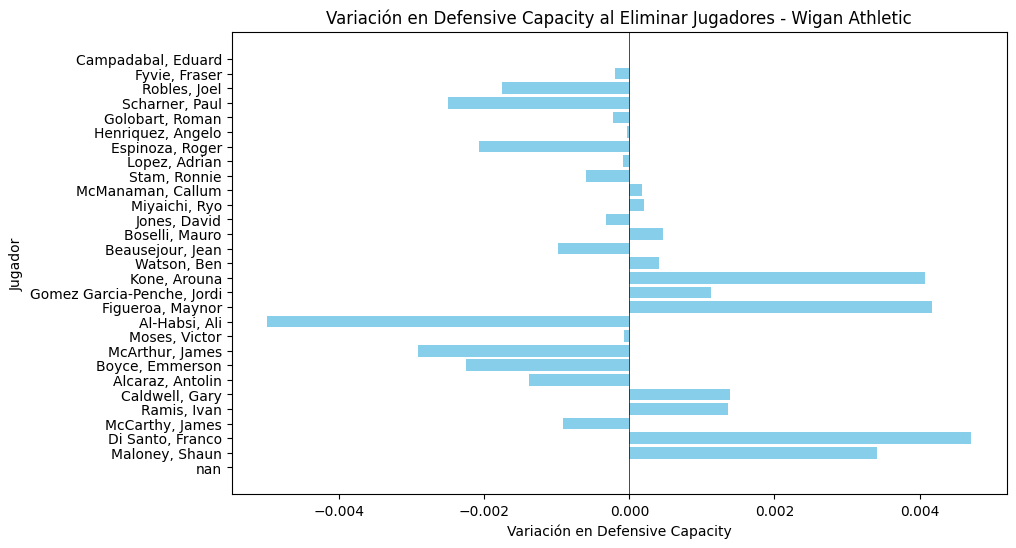

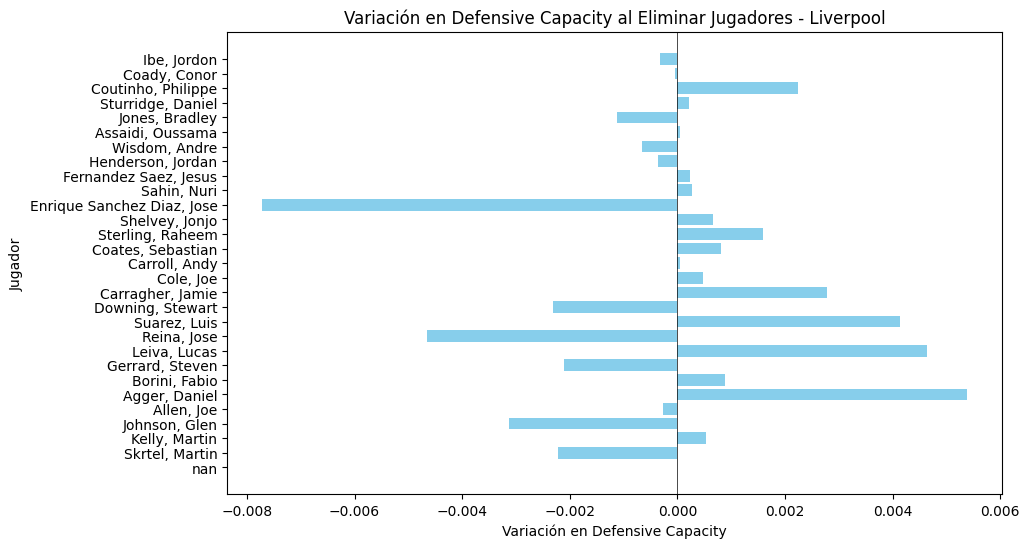

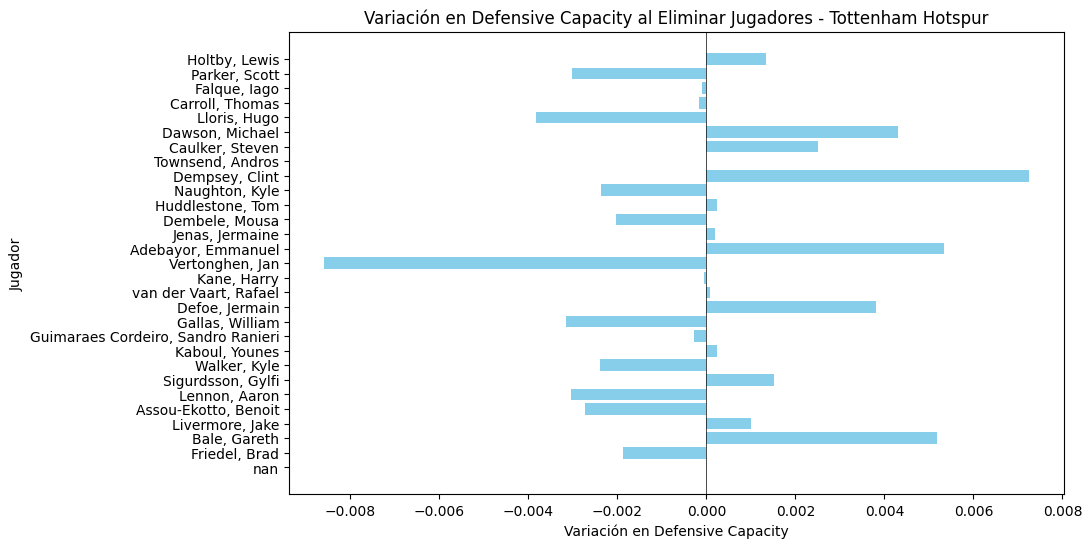

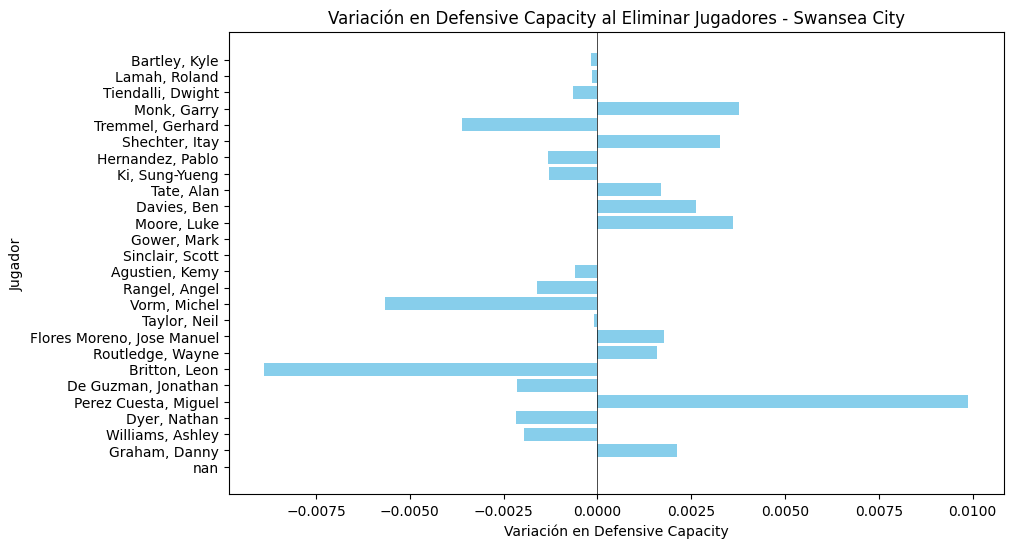

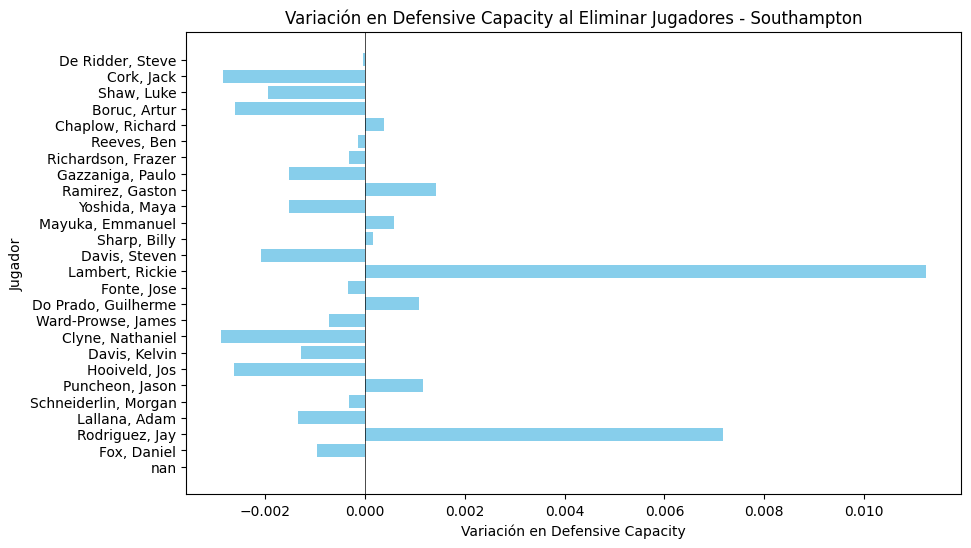

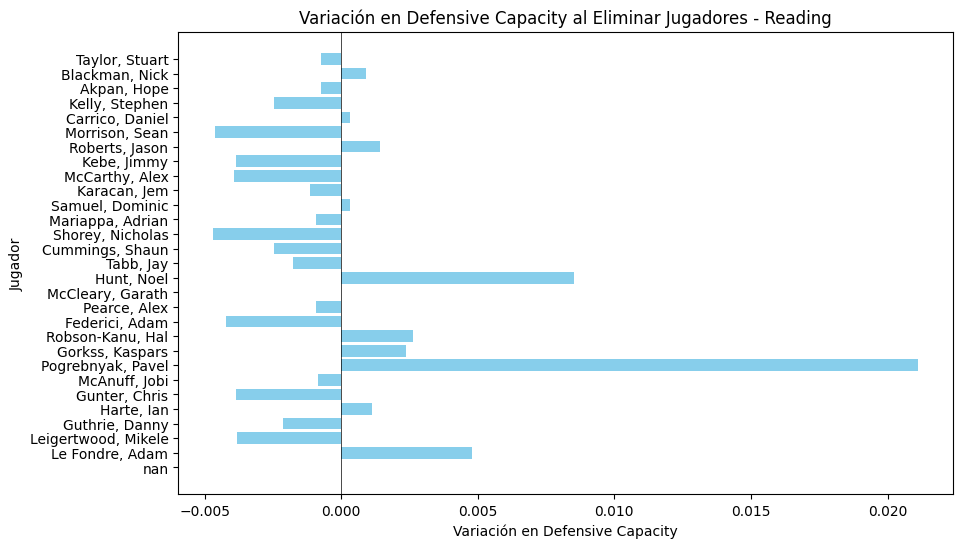

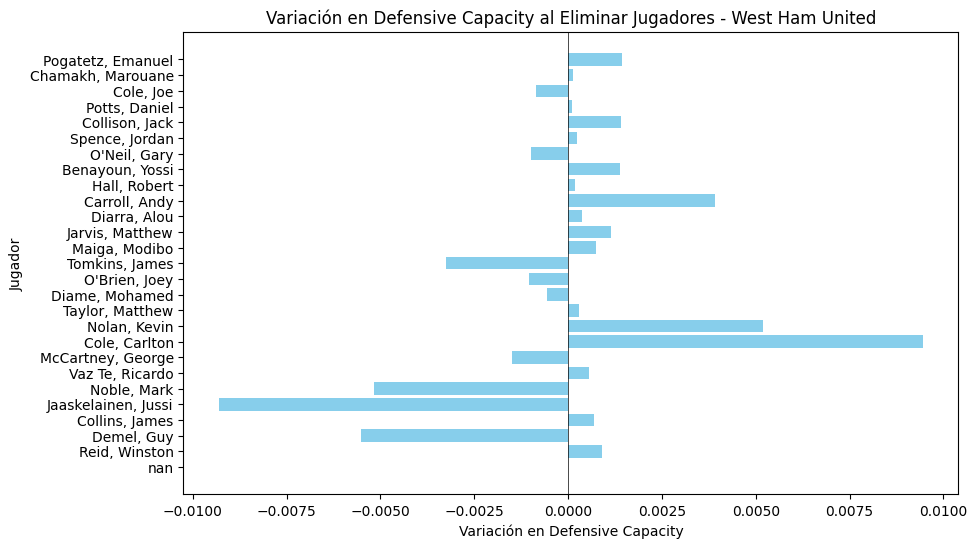

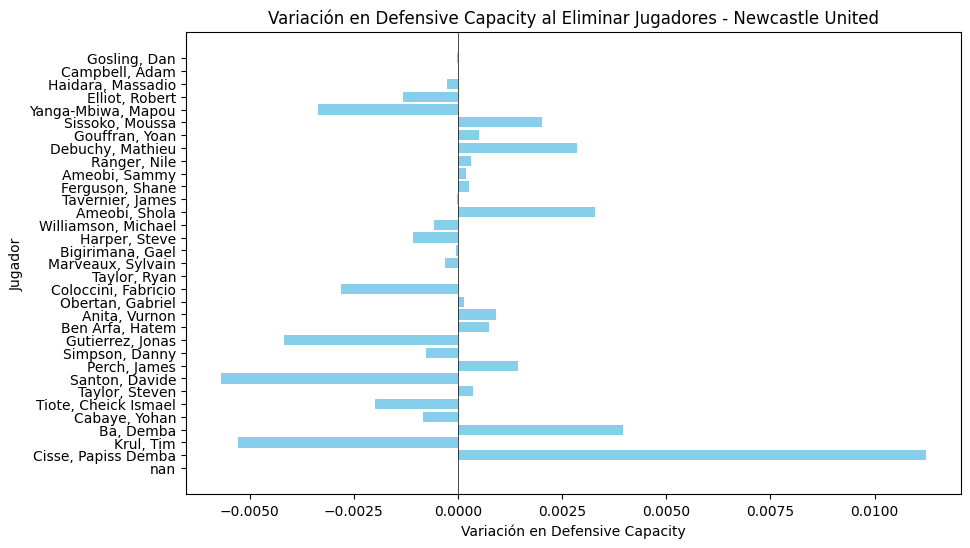

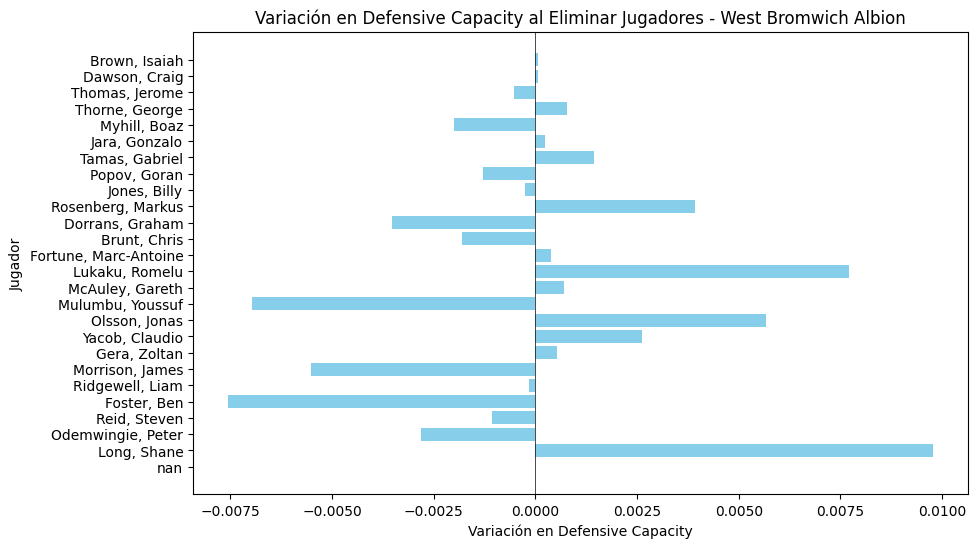

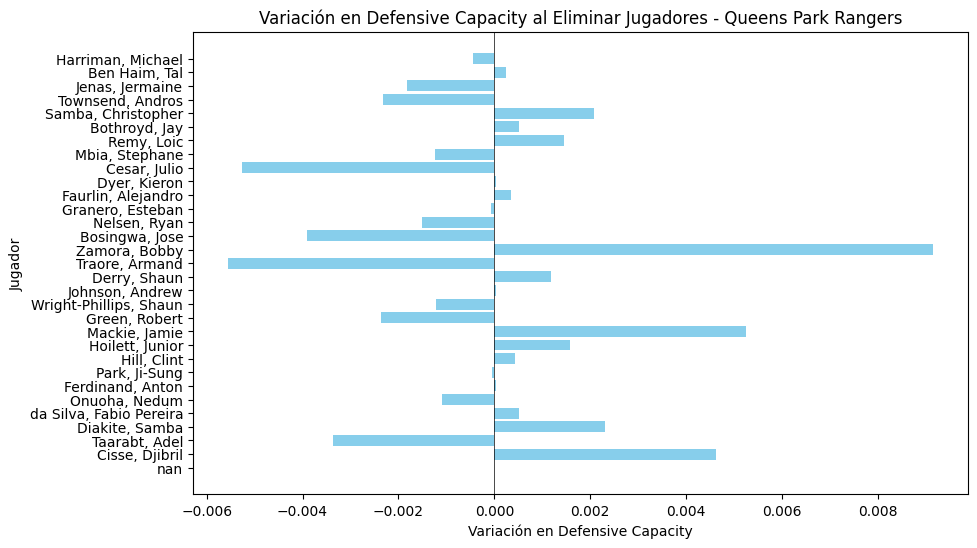

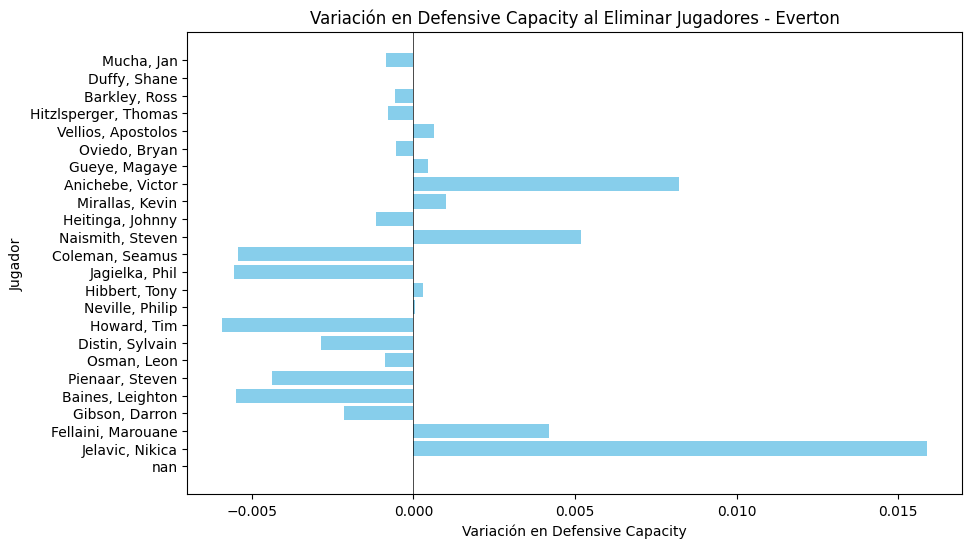

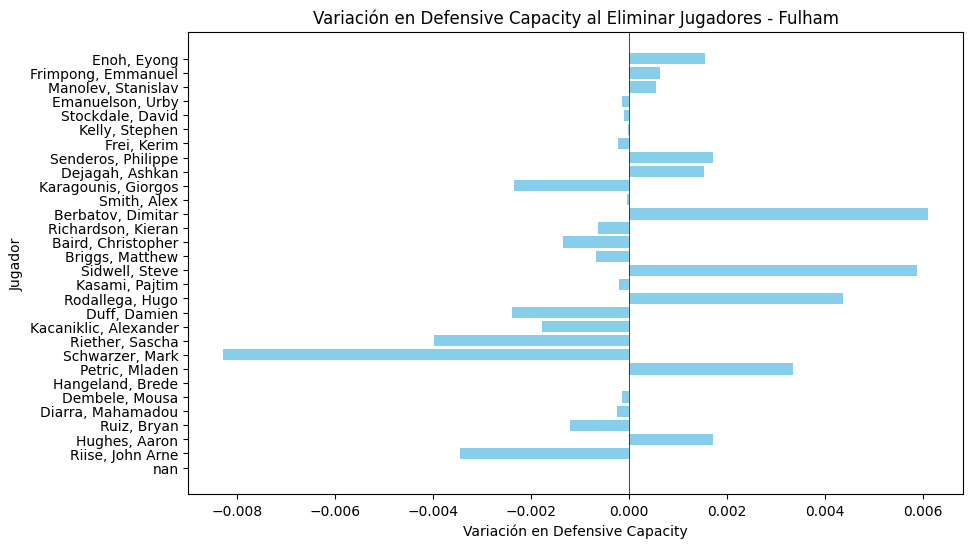

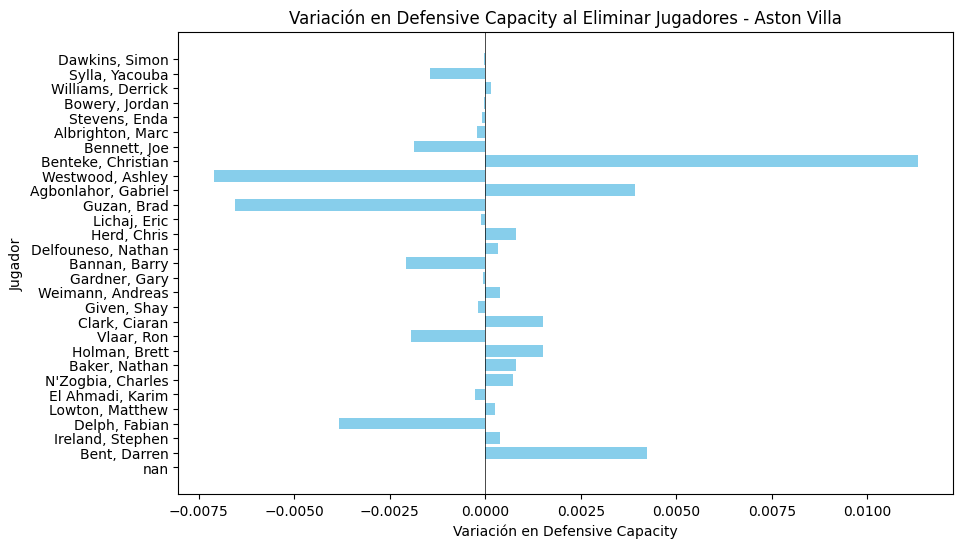

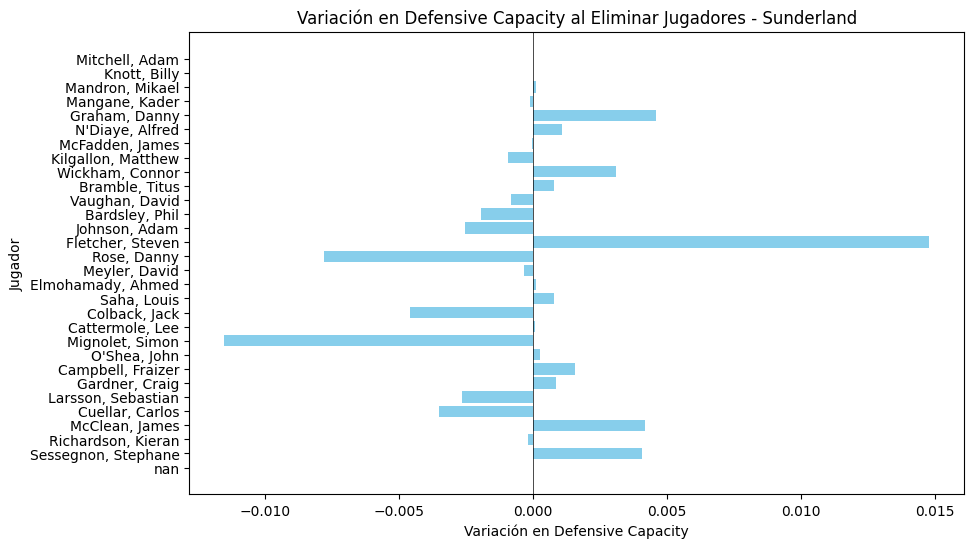

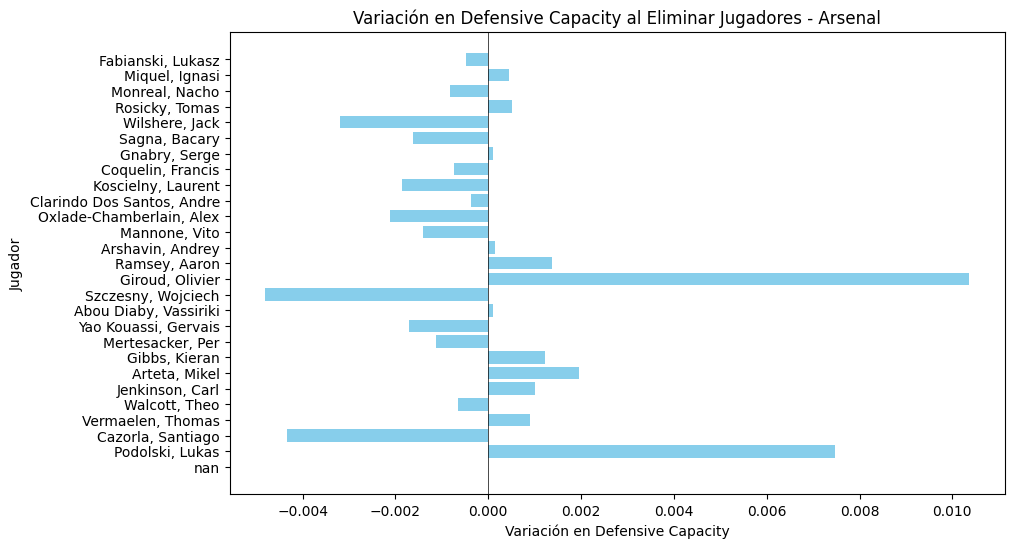

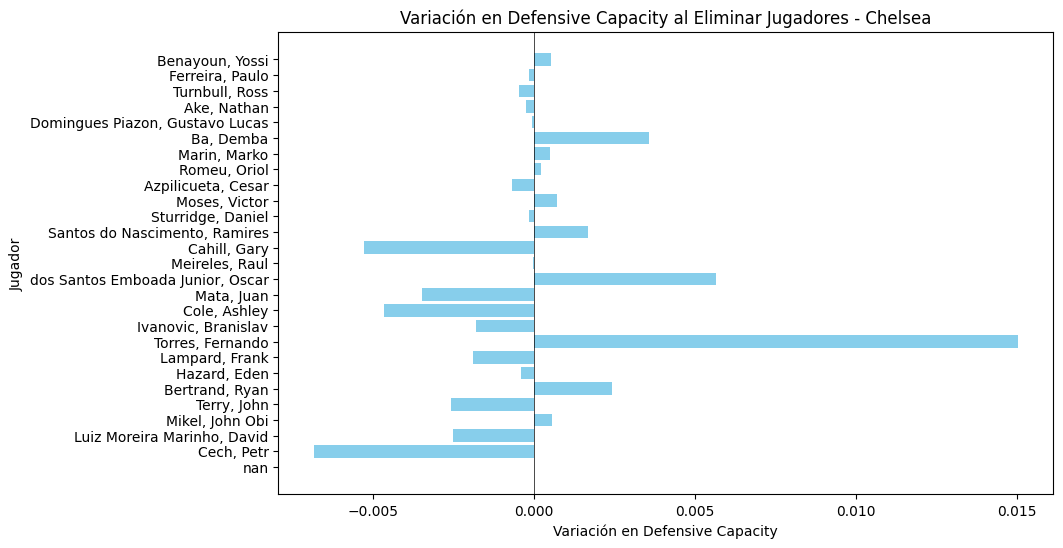

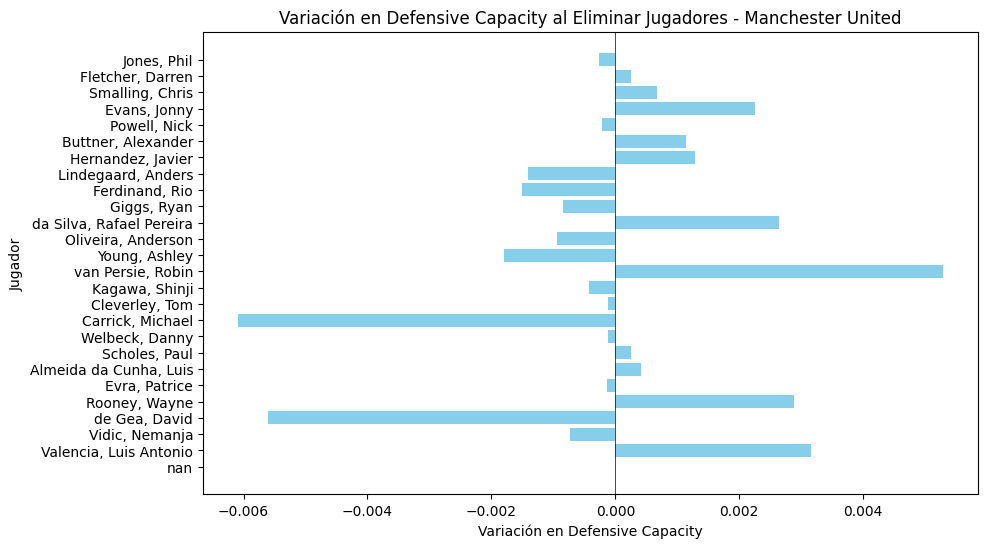

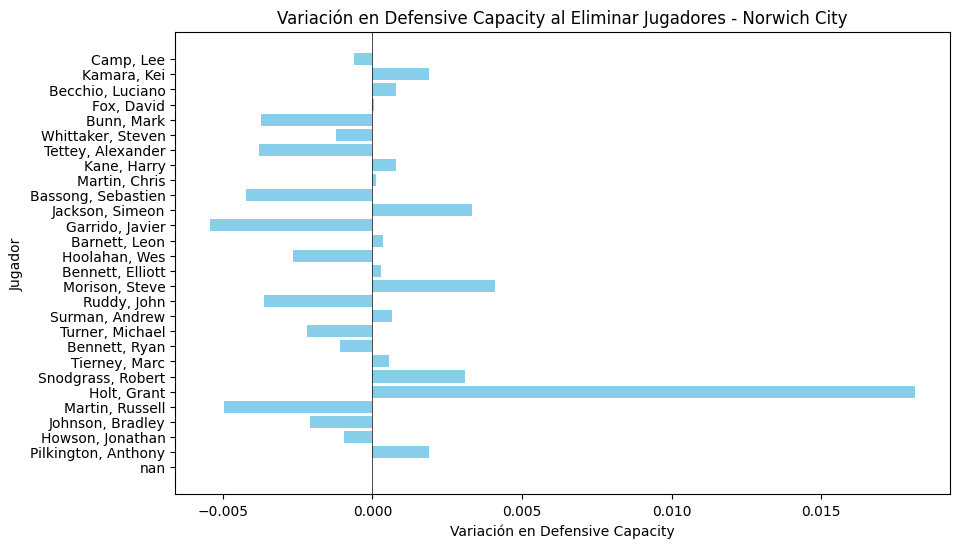

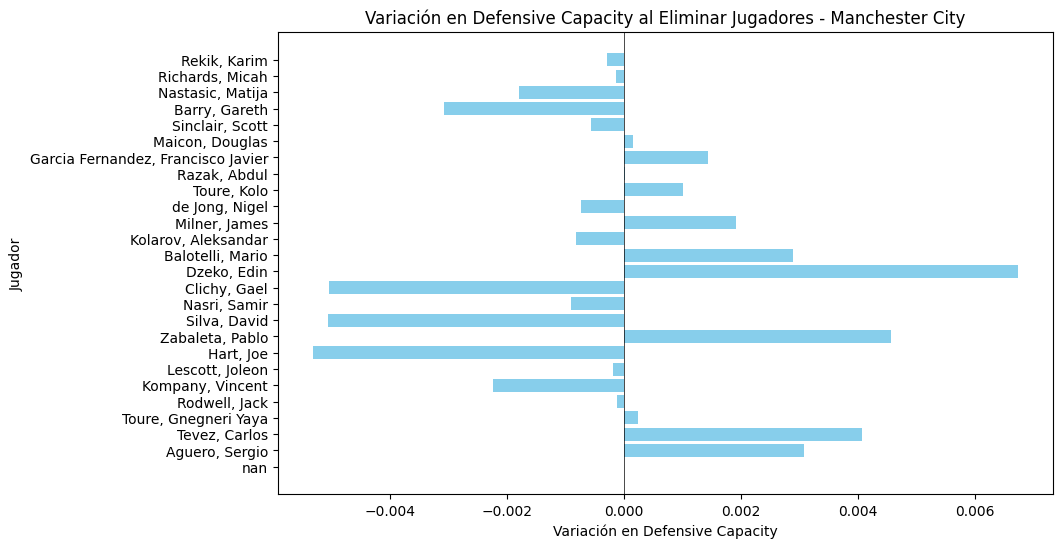

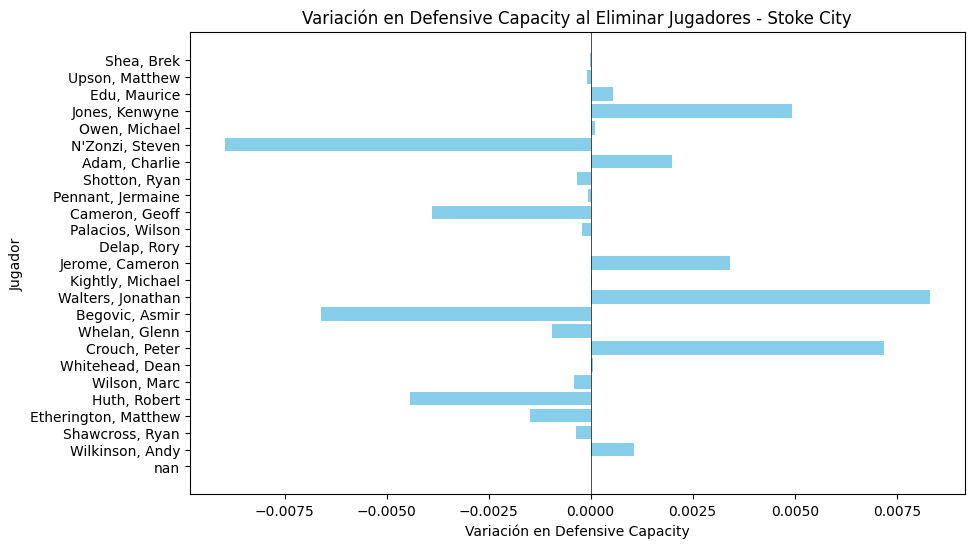

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Suponemos que ya tienes el team_stats calculado como en el código original

# Lista para almacenar la variación de defensive capacity al eliminar jugadores
team_variation_stats = []

# Recorremos cada equipo
for team_stat in team_stats:
    team_id = team_stat['team_id']
    team_name = team_stat['team_name']
    original_defensive_capacity = team_stat['defensive_capacity']

    # Filtramos los jugadores del equipo actual
    team_players = df[df['team_id'] == team_id]['playerName'].unique()

    # Recorremos cada jugador del equipo
    for player_name in team_players:
        # Recalcular el defensive capacity sin el jugador actual
        team_df_without_player = df[(df['team_id'] == team_id) & (df['playerName'] != player_name)]
        
        total_defensive_events = 0
        successful_defensive_events = 0

        for event, outcomes in defensive_events.items():
            # Calcular eventos defensivos sin el jugador actual
            if event == 'Foul':
                total_event_count = team_df_without_player[(team_df_without_player['description'] == event) & (team_df_without_player['outcome'] == 0)].shape[0]
            else:
                total_event_count = team_df_without_player[team_df_without_player['description'] == event].shape[0]
            
            total_defensive_events += total_event_count

            if 'successful' in outcomes:
                if event == 'Foul':
                    successful_event_count = team_df_without_player[(team_df_without_player['description'] == event) & (team_df_without_player['outcome'] == 0)].shape[0]
                else:
                    successful_event_count = team_df_without_player[(team_df_without_player['description'] == event) & (team_df_without_player['outcome'] == outcomes['successful'])].shape[0]
                
                successful_defensive_events += successful_event_count

        # Calcular el defensive capacity sin el jugador
        defensive_capacity_without_player = successful_defensive_events / total_defensive_events if total_defensive_events > 0 else 0

        # Calcular la variación en defensive capacity
        variation = defensive_capacity_without_player - original_defensive_capacity

        # Guardar los resultados
        team_variation_stats.append({
            'team_id': team_id,
            'team_name': team_name,
            'player_name': player_name,
            'original_defensive_capacity': original_defensive_capacity,
            'defensive_capacity_without_player': defensive_capacity_without_player,
            'variation': variation
        })

# Crear un DataFrame con los resultados
df_variations = pd.DataFrame(team_variation_stats)

# Convertir los nombres de los jugadores a string para evitar el error
df_variations['player_name'] = df_variations['player_name'].astype(str)

# Ejemplo de cómo hacer un gráfico para un equipo
for team_name in df_variations['team_name'].unique():
    team_data = df_variations[df_variations['team_name'] == team_name]
    plt.figure(figsize=(10, 6))
    plt.barh(team_data['player_name'], team_data['variation'], color='skyblue')
    plt.axvline(0, color='black', linewidth=0.5)
    plt.title(f'Variación en Defensive Capacity al Eliminar Jugadores - {team_name}')
    plt.xlabel('Variación en Defensive Capacity')
    plt.ylabel('Jugador')
    plt.show()
